## Protodash: NHANES (CDC) data example
- This notebook shows an example of how to use the ProtodashExplainer defined in [AIX360](https://github.com/IBM/AIX360/) to generate prototypes from (training/test) data. The notebook uses one of the [NHANES CDC questionnaire dataset](https://wwwn.cdc.gov/nchs/nhanes/search/datapage.aspx?Component=Questionnaire&CycleBeginYear=2013) related to incomes of individuals.
- ProtodashExplainer is an implementation of the [Protodash algorithm](https://arxiv.org/abs/1707.01212)

### Protodash Explainer examples

#### Import statements

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

from aix360.algorithms.protodash import ProtodashExplainer, get_Gaussian_Data
from aix360.datasets import CDCDataset

#### Load NHANES dataset from CDC 

In [10]:
nhanes = CDCDataset()
nhanes_files = nhanes.get_csv_file_names()
(nhanesinfo, _, _) = nhanes._cdc_files_info()

<a name="explore"></a>
#### Explore NHANES Income questionnaire dataset

Now let us explore the income questionnaire dataset and find out the types of responses received in the survey. Each column in this dataset corresponds to a question and each row denotes the answers given by a respondent to those questions. Both column names and answers by respondents are encoded. For example, 'SEQN' denotes the sequence number assigned to a respondent and 'IND235' corresponds to a question about monthly family income. As seen below, in most cases a value of 1 implies "Yes" to the question, while a value of 2 implies "No". More details about the income questionaire and how questions and answers are encoded can be seen [here](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/INQ_H.htm)

|Column  |Description                    | Values and Meaning|
|-------|----------------------------|---------|
|SEQN   | Respondent sequence number |
|INQ020 | Income from wages/salaries |1->Yes, 2->No, 7->Refused, 9->Don't know|
|INQ012 | Income from self employment|1->Yes, 2->No, 7->Refused, 9->Don't know|
|INQ030 | Income from Social Security or RR |1->Yes, 2->No, 7->Refused, 9->Don't know|
|INQ060 | Income from other disability pension |1->Yes, 2->No, 7->Refused, 9->Don't know|
|INQ080 | Income from retirement/survivor pension |1->Yes, 2->No, 7->Refused, 9->Don't know|
|INQ090 | Income from Supplemental Security Income |1->Yes, 2->No, 7->Refused, 9->Don't know|
|INQ132 | Income from state/county cash assistance |1->Yes, 2->No, 7->Refused, 9->Don't know|
|INQ140 | Income from interest/dividends or rental |1->Yes, 2->No, 7->Refused, 9->Don't know|
|INQ150 | Income from other sources |1->Yes, 2->No, 7->Refused, 9->Don't know|
|IND235 | Monthly family income |1-12->Increasing income brackets, 77->Refused, 99->Don't know|
|INDFMMPI | Family monthly poverty level index |0-5->Higher value more affluent|
|INDFMMPC | Family monthly poverty level category |1-3->Increasing INDFMMPI brackets, 7->Refused, 9->Don't know|
|INQ244 | Family has savings more than $5000 |1->Yes, 2->No, 7->Refused, 9->Don't know|
|IND247 | Total savings/cash assets for the family |1-6->Increasing savings brackets, 77->Refused, 99->Don't know|

In [11]:
# replace encoded column names by the associated question text. 
df_inc = nhanes.get_csv_file('INQ_H.csv')
df_inc.columns[0]
dict_inc = {
'SEQN': 'Respondent sequence number', 
'INQ020': 'Income from wages/salaries',
'INQ012': 'Income from self employment',
'INQ030':'Income from Social Security or RR',
'INQ060':  'Income from other disability pension', 
'INQ080':  'Income from retirement/survivor pension',
'INQ090':  'Income from Supplemental Security Income',
'INQ132':  'Income from state/county cash assistance', 
'INQ140':  'Income from interest/dividends or rental', 
'INQ150':  'Income from other sources',
'IND235':  'Monthly family income',
'INDFMMPI':  'Family monthly poverty level index', 
'INDFMMPC':  'Family monthly poverty level category',
'INQ244':  'Family has savings more than $5000',
'IND247':  'Total savings/cash assets for the family'
}
qlist = []
for i in range(len(df_inc.columns)):
    qlist.append(dict_inc[df_inc.columns[i]])
df_inc.columns = qlist
print("Answers given by some respondents to the income questionnaire:")
df_inc.head(5)

Answers given by some respondents to the income questionnaire:


,Respondent sequence number,Income from wages/salaries,Income from self employment,Income from Social Security or RR,Income from other disability pension,Income from retirement/survivor pension,Income from Supplemental Security Income,Income from state/county cash assistance,Income from interest/dividends or rental,Income from other sources,Monthly family income,Family monthly poverty level index,Family monthly poverty level category,Family has savings more than $5000,Total savings/cash assets for the family
0,73557.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,4.0,0.86,1.0,9.0,NaN
1,73558.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,5.0,0.92,1.0,1.0,NaN
2,73559.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0,10.0,4.37,3.0,NaN,NaN
3,73560.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,9.0,2.52,3.0,NaN,NaN
4,73561.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,11.0,5.00,3.0,NaN,NaN


Number of respondents to Income questionnaire: 10175
Distribution of answers to 'monthly family income' and 'Family savings' questions:


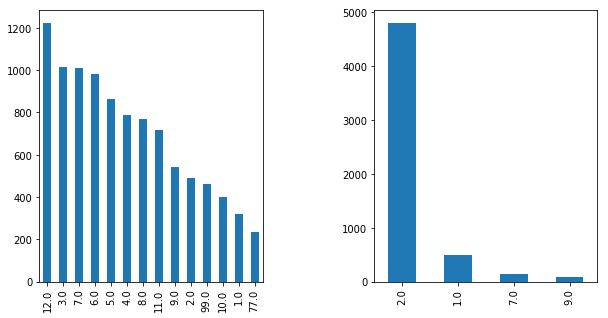

In [12]:
print("Number of respondents to Income questionnaire:", df_inc.shape[0])
print("Distribution of answers to \'monthly family income\' and \'Family savings\' questions:")

fig, axes = plt.subplots(1, 2, figsize=(10,5))
fig.subplots_adjust(wspace=0.5)
hist1 = df_inc['Monthly family income'].value_counts().plot(kind='bar', ax=axes[0])
hist2 = df_inc['Family has savings more than $5000'].value_counts().plot(kind='bar', ax=axes[1])
plt.show()

<a name="study1"></a>
#### Summarize NHANES Income Questionnaire dataset using Prototypes

Consider a social scientist who would like to quickly obtain a summary report of this dataset in terms of types of people that span this dataset. Is it possible to summarize this dataset by looking at answers given by a few representative/prototypical respondents? 

We now show how the ProtodashExplainer can be used to obtain a few prototypical respondents (about 10 in this example) that span the diverse set of individuals answering the income questionnaire making it easy for the social scientist to summarize the dataset.

In [13]:
# convert pandas dataframe to numpy
data = df_inc.to_numpy()

#sort the rows by sequence numbers in 1st column 
idx = np.argsort(data[:, 0])  
data = data[idx, :]

# replace nan's (missing values) with 0's
original = data
original[np.isnan(original)] = 0

# delete 1st column (sequence numbers)
original = original[:, 1:]

# one hot encode all features as they are categorical
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoded = onehot_encoder.fit_transform(original)

explainer = ProtodashExplainer()

# call protodash explainer
# S contains indices of the selected prototypes
# W contains importance weights associated with the selected prototypes 
(W, S, _) = explainer.explain(onehot_encoded, onehot_encoded, m=10) 

/opt/anaconda2/envs/env3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/opt/anaconda2/envs/env3/lib/python3.6/site-packages/cvxopt/coneprog.py:2111: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'x' in initvals:
/opt/anaconda2/envs/env3/lib/python3.6/site-packages/cvxopt/coneprog.py:2116: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -2.0000e+04  4e+00  1e+00  1e+00
 1:  3.9668e+01 -4.7629e+05  9e+01  1e+00  1e+00
 2:  3.1760e+00 -2.0407e+06  5e+02  1e+00  1e+00
 3:  2.2364e+01 -1.2096e+08  2e+04  1e+00  1e+00
 4:  3.7900e+01 -2.8195e+11  8e+07  1e+00  1e+00
 5:  4.5923e+05 -3.1803e+18  3e+18  5e-13  6e-03
 6:  4.5923e+05 -3.1803e+16  3e+16  5e-15  1e-03
 7:  4.5923e+05 -3.1803e+14  3e+14  2e-16  4e-05
 8:  4.5923e+05 -3.1803e+12  3e+12  3e-17  5e-07
 9:  4.5919e+05 -3.1804e+10  3e+10  9e-17  5e-09
10:  4.5530e+05 -3.1930e+08  3e+08  1e-16  4e-11
11:  2.5225e+05 -3.8443e+06  4e+06  2e-16  5e-13
12:  3.9004e+04 -7.9611e+04  1e+05  2e-16  6e-14
13:  5.5412e+03 -6.2407e+03  1e+04  3e-16  1e-14
14:  7.6180e+02 -9.4756e+02  2e+03  2e-16  1e-14
15:  9.5649e+01 -1.4835e+02  2e+02  1e-16  2e-15
16:  7.4120e+00 -2.6974e+01  3e+01  8e-17  0e+00
17: -2.7382e+00 -7.1060e+00  4e+00  6e-17  1e-16
18: -3.7687e+00 -4.4831e+00  7e-01  6e-17  2e-17
19: -3.8264e+00 -3.86

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -8.0000e+04  2e+01  1e+00  1e+00
 1:  9.2714e+01 -2.5967e+06  4e+02  1e+00  1e+00
 2:  2.2268e+02 -4.6524e+06  9e+02  1e+00  1e+00
 3:  2.0020e+02 -8.8808e+06  2e+03  1e+00  1e+00
 4:  7.0492e+01 -5.7775e+07  1e+04  1e+00  1e+00
 5:  1.3244e+02 -7.4658e+08  2e+05  1e+00  1e+00
 6:  1.5210e+02 -4.0931e+11  9e+07  1e+00  1e+00
 7:  7.7582e+08 -8.2049e+18  8e+18  5e-13  2e-03
 8:  7.7582e+08 -8.2049e+16  8e+16  5e-15  1e-03
 9:  7.7582e+08 -8.2051e+14  8e+14  2e-16  3e-05
10:  7.7581e+08 -8.2207e+12  8e+12  2e-16  4e-07
11:  7.7478e+08 -9.7860e+10  1e+11  2e-16  5e-09
12:  7.0303e+08 -1.4965e+10  2e+10  1e-16  7e-10
13:  2.0381e+08 -9.8474e+09  1e+10  2e-16  3e-10
14:  8.2855e+07 -2.7731e+08  4e+08  2e-16  1e-11
15:  1.3061e+07 -1.5647e+07  3e+07  3e-16  2e-12
16:  1.8737e+06 -2.0712e+06  4e+06  2e-16  5e-13
17:  2.6814e+05 -2.9803e+05  6e+05  2e-16  1e-13
18:  3.8192e+04 -4.2849e+04  8e+04  2e-16  6e-14
19:  5.3795e+03 -6.23

In [14]:
# Display the prototypes along with their computed weights
inc_prototypes = df_inc.iloc[S, :].copy()
# Compute normalized importance weights for prototypes
inc_prototypes["Weights of Prototypes"] = np.around(W/np.sum(W), 2) 
inc_prototypes

,Respondent sequence number,Income from wages/salaries,Income from self employment,Income from Social Security or RR,Income from other disability pension,Income from retirement/survivor pension,Income from Supplemental Security Income,Income from state/county cash assistance,Income from interest/dividends or rental,Income from other sources,Monthly family income,Family monthly poverty level index,Family monthly poverty level category,Family has savings more than $5000,Total savings/cash assets for the family,Weights of Prototypes
1737,75294.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,0.67,1.0,NaN,NaN,0.18
2561,76118.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,7.0,1.97,3.0,2.0,1.0,0.14
343,73900.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,12.0,5.00,3.0,NaN,NaN,0.11
6778,80335.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,6.0,2.88,3.0,2.0,1.0,0.09
8376,81933.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,0.73,1.0,2.0,1.0,0.07
718,74275.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,5.0,1.85,2.0,1.0,NaN,0.11
821,74378.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,8.0,3.48,3.0,2.0,2.0,0.08
4068,77625.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,4.0,0.99,1.0,NaN,NaN,0.09
21,73578.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,99.0,NaN,1.0,2.0,1.0,0.08
3620,77177.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,11.0,4.77,3.0,NaN,NaN,0.06


#### Explanation:
The 10 people shown above (i.e. 5 prototypes) are representative of the income questionnaire according to Protodash. Firstly, in the distribution plot for family finance related questions we saw that there roughly were 5 times as many people not having savings in excess of $5000 compared with others. Our prototypes also have a similar spread which is reassuring. Also for monthly family income we get a more even spread over the more commonly occuring categories. This is kind of a spot check to see if our prototypes actually match the distribution of values in the dataset.

Looking at the other questions in the questionnaire and the corresponding answers given by the prototypical people above the social scientist realizes that most people are employeed (3rd question) and work for an organization earning through salary/wages (1st two questions). Most of them are also young (5th question) and fit to work (4th question). However, they don't seem to have much savings (last question). These insights that the social scientist has acquired from studying the prototypes could be conveyed also to the appropriate government authorities that affect future public policy decisions.

#### Summarize Gaussian (simulated) data using prototypes

In [15]:
# generate normalized gaussian data X, Y with 100 features and 300 & 4000 observations respectively
(X, Y) = get_Gaussian_Data(100, 300, 4000)
print(X.shape, Y.shape)

(300, 100) (4000, 100)


In [16]:
(W, S, setValues) = explainer.explain(X, Y, m=5, kernelType='Gaussian', sigma=2)

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -2.0000e+04  4e+00  1e+00  1e+00
 1:  3.2221e+00 -8.5266e+04  2e+01  1e+00  1e+00
 2:  2.7001e-01 -1.6914e+07  4e+03  1e+00  1e+00
 3:  4.3897e+07 -3.9165e+14  4e+14  3e-13  6e-06
 4:  4.3897e+07 -3.9165e+12  4e+12  3e-15  5e-06
 5:  4.3894e+07 -3.9210e+10  4e+10  1e-16  9e-08
 6:  4.3518e+07 -4.3607e+08  5e+08  2e-16  1e-09
 7:  2.4531e+07 -2.8978e+07  5e+07  1e-16  1e-10
 8:  3.6567e+06 -5.7170e+06  9e+06  2e-16  8e-13
 9:  5.4550e+05 -5.8860e+05  1e+06  3e-16  9e-13
10:  7.8453e+04 -8.8545e+04  2e+05  1e-16  5e-14
11:  1.1222e+04 -1.2517e+04  2e+04  3e-16  4e-14
12:  1.5941e+03 -1.8062e+03  3e+03  5e-16  5e-14
13:  2.2267e+02 -2.6432e+02  5e+02  3e-16  3e-15
14:  2.9593e+01 -4.0124e+01  7e+01  9e-17  6e-15
15:  3.2462e+00 -6.6869e+00  1e+01  2e-16  3e-15
16: -3.8432e-02 -1.4066e+00  1e+00  3e-16  9e-16
17: -3.4476e-01 -4.9425e-01  1e-01  2e-16  3e-16
18: -3.5526e-01 -3.5919e-01  4e-03  3e-16  9e-17
19: -3.5527e-01 -3.55

In [17]:
print(S, W)

[3940 2539 2168 2189 1170] [0.20611975 0.24524152 0.19131865 0.17175151 0.16123794]


In [18]:
Y[S, :]

array([[ 7.54620330e-02,  2.21559502e-03, -2.60390535e-04,
         1.32841035e-03, -6.39270748e-02,  1.60731744e-01,
         1.00469456e-01,  2.30534177e-02, -2.62244674e-02,
        -7.41659651e-02,  5.02276642e-03, -1.99183986e-02,
        -3.11979874e-02,  9.58197735e-04, -3.98023293e-03,
        -3.29754316e-01, -8.57806586e-02, -5.55736043e-02,
        -1.14853770e-01,  1.54146242e-01, -1.06148650e-02,
         4.69670224e-02, -1.11019441e-01,  2.79269162e-02,
        -1.53149165e-02, -1.21122605e-01, -1.03368232e-01,
         9.06247095e-04,  1.39727121e-01,  4.64877100e-02,
        -9.19127100e-02, -1.99338641e-01,  5.17279612e-02,
        -6.04863165e-02,  3.31939372e-02, -5.58036293e-02,
         5.00831453e-03,  2.91216408e-02, -1.19168965e-01,
         5.18582471e-02, -7.42898829e-02, -2.37439618e-02,
        -7.45301815e-02, -4.90749528e-02, -2.48565755e-02,
         1.38223978e-01, -1.51096859e-01,  1.26429938e-01,
         1.40878748e-01, -1.20653470e-03, -1.99680954e-0